<a href="https://colab.research.google.com/github/ShaliniAnandaPhD/Virtual-Pet-Dev_RLHF/blob/main/Virtual_Pet_Training_using_RLHF_(simple).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. **Objective**
   - **Primary Objective:** To develop a virtual pet capable of learning and performing specific actions (like sitting, fetching, etc.) through the combined application of Reinforcement Learning (RL) and human feedback.
   - **Secondary Objectives:**
     - To evaluate the effectiveness of RL combined with human feedback compared to RL alone.
     - To enhance user engagement and provide an intuitive interface for human feedback.

 2. **Scope**
   - **Actions to Train:**
     - **Basic Commands:** Sit, Stay, Come.
     - **Advanced Commands:** Fetch, Roll Over, Play Dead.
     - **Interactive Behaviors:** Responding to virtual environmental changes, interacting with virtual objects or other virtual pets.
   - **Criteria for Successful Action:**
     - **Accuracy:** The virtual pet performs the action correctly in response to the command.
     - **Consistency:** The pet consistently performs the action correctly over time.
     - **Adaptability:** The pet can adapt its response based on different cues or environments.
   - **RL and Human Feedback Integration:**
     - **Reinforcement Learning:** Implement a reward system where the virtual pet learns through trial and error, guided by a reward function.
     - **Human Feedback:** Integrate a mechanism for users to provide direct feedback (like praising or correcting), which influences the pet's learning process.
     - **Feedback Loop:** Ensure there's a system in place where the RL algorithm can adapt based on human feedback, enhancing the training effectiveness.

  3. **Deliverables**
   - **A Virtual Pet Simulation:** A software application where the virtual pet can be trained and interacted with.
   - **Training Module:** A user-friendly interface for providing human feedback and monitoring the pet's progress.
   - **Performance Reports:** Regular reports on the pet's learning progress, highlighting areas of success and those needing improvement.

 4. **Challenges and Considerations**
   - **Balancing RL and Human Feedback:** Finding the optimal balance where both RL and human feedback complement each other effectively.
   - **User Experience:** Designing an engaging and intuitive interface for users to interact with their virtual pet.
   - **Ethical Considerations:** Ensuring the virtual pet’s behavior does not promote harmful actions or reactions.

 5. **Metrics for Success**
   - **Learning Speed:** How quickly the virtual pet acquires new behaviors.
   - **Behavioral Accuracy:** The precision and appropriateness of the pet’s responses to commands.
   - **User Satisfaction:** Feedback from users regarding their experience training and interacting with the virtual pet.

In [1]:
!pip install tensorflow

In [2]:
!pip install torch torchvision

In [3]:
!pip install gym

In [4]:
import tensorflow as tf
import torch
import gym


Creating a simulation environment

In [32]:
import gym
from gym import spaces
import numpy as np

class VirtualPetEnv(gym.Env):
    def __init__(self):
        super(VirtualPetEnv, self).__init__()
        self.action_space = spaces.Discrete(3)  # Actions: move_left, move_right, interact
        self.observation_space = spaces.Box(low=0, high=10, shape=(2,), dtype=np.float32)
        self.reset()

    def step(self, action):
        pet_pos, obj_pos = self.state
        reward = 0
        done = False

        if action == 0:  # Move left
            pet_pos = max(0, pet_pos - 1)
        elif action == 1:  # Move right
            pet_pos = min(9, pet_pos + 1)
        elif action == 2:  # Interact
            if pet_pos == obj_pos:
                reward = 10  # Reward for successful interaction
                done = True
            else:
                reward = -5  # Penalty for incorrect interaction

        self.state = (pet_pos, obj_pos)
        return np.array(self.state, dtype=np.float32), reward, done, {}

    def reset(self):
        self.state = (5, np.random.randint(0, 10))
        return np.array(self.state, dtype=np.float32)

    def render(self, mode='human'):
        grid = ['_'] * 10
        pet_pos, obj_pos = self.state
        grid[pet_pos] = 'P'
        grid[obj_pos] = 'O'
        print(''.join(grid))

    def close(self):
        pass



Define the Q-learning agent

In [33]:
env = VirtualPetEnv()
observation = env.reset()
for _ in range(10):
    action = env.action_space.sample()  # Random action
    observation, reward, done, info = env.step(action)
    env.render()  # Text-based rendering
    if done:
        print(f"Finished with reward: {reward}")
        break
env.close()



__O___P___
__O__P____
__O___P___
__O__P____
__O___P___
__O___P___
__O____P__
__O_____P_
__O____P__
__O____P__


Define the q learning agent

In [34]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.n_states = n_states
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.q_table = np.zeros((n_states, n_actions))

    def choose_action(self, state_index):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            return np.argmax(self.q_table[state_index])

    def learn(self, state_index, action, reward, next_state_index):
        predict = self.q_table[state_index, action]
        target = reward + self.gamma * np.max(self.q_table[next_state_index])
        self.q_table[state_index, action] += self.lr * (target - predict)
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)




Discretizing the State Space

In [35]:
def discretize_state(state):
    pet_pos, obj_pos = state
    state_index = int(pet_pos) * 10 + int(obj_pos)
    return state_index




Incorporating Human Feedback

In [36]:
import matplotlib.pyplot as plt

def human_feedback(action, original_reward):
    if action == 2:  # If the action is 'interact'
        if original_reward > 0:  # Correct interaction
            return original_reward + 5
        else:  # Incorrect interaction
            return original_reward - 5
    return original_reward




Training the agent and visualization

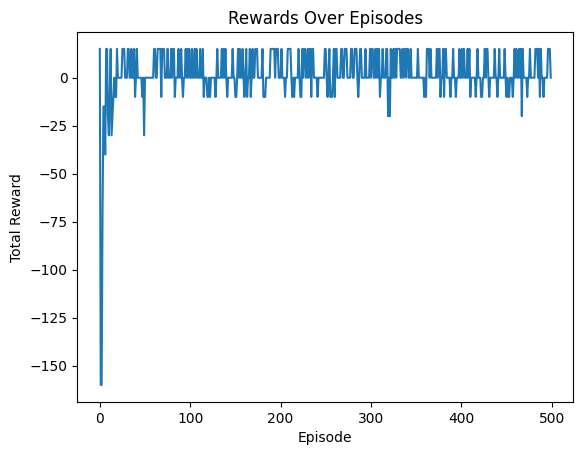

In [37]:
import matplotlib.pyplot as plt

# Initialize the environment and the agent
env = VirtualPetEnv()
n_states = 100  # 10 pet positions * 10 object positions
n_actions = env.action_space.n
agent = QLearningAgent(n_states, n_actions)

# Training loop with episode rewards recording
n_episodes = 500
episode_rewards = []

for episode in range(n_episodes):
    state = discretize_state(env.reset())
    total_reward = 0
    done = False

    for step in range(50):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        adjusted_reward = human_feedback(action, reward)
        next_state_index = discretize_state(next_state)
        agent.learn(state, action, adjusted_reward, next_state_index)

        state = next_state_index
        total_reward += adjusted_reward

        if done:
            break

    episode_rewards.append(total_reward)

# Visualizing the learning progress
plt.plot(episode_rewards)
plt.title('Rewards Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


Visualizing the Agent's Learned Policy

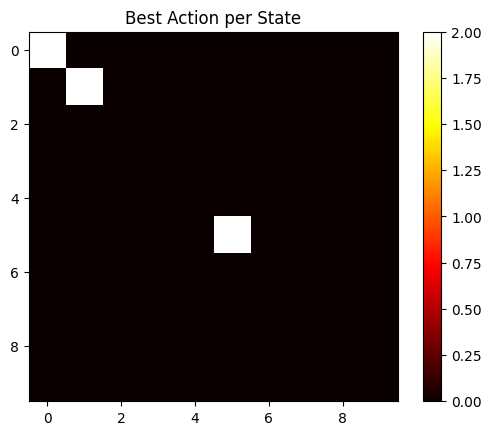

In [38]:
best_actions = np.argmax(agent.q_table, axis=1).reshape((10, 10))
plt.imshow(best_actions, cmap='hot', interpolation='nearest')
plt.title('Best Action per State')
plt.colorbar()
plt.show()


Testing the agent

In [ ]:
def test_agent(env, agent, n_tests):
    total_rewards = 0
    for _ in range(n_tests):
        state = discretize_state(env.reset())
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            state = discretize_state(next_state)
            total_rewards += reward
    avg_reward = total_rewards / n_tests
    print(f"Average Reward after {n_tests} tests: {avg_reward}")

test_agent(env, agent, 100)
